# Logit and assignment

In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario)

'../../model/base/distribution.zip'

In [5]:
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
pt = stepmodel.read_zip(training_folder + r'model/{scen}/pruning_pt_pathfinder.zip'.format(scen=scenario))
car = stepmodel.read_zip(training_folder + r'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.42it/s]


In [6]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

In [7]:
scenario = 'project'

In [8]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

In [9]:
var['preparation_logit']

parameter
time        -0.00055
price             -1
transfers      -0.25
mode               1
pt_mode            1
pt_path            1
Name: project, dtype: object

In [10]:
kwargs = var['preparation_logit'].to_dict()
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 1,
 'pt_path': 1}

# LOGIT SCALES

In [11]:
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 1,
 'pt_path': 1}

In [12]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [13]:
sm.utility_values.T

value          time  price  ntransfers  mode_utility
segment                                             
root       -0.00055   -1.0       -0.25           1.0
car_owner  -0.00055   -1.0       -0.25           1.0
pt_captive -0.00055   -1.0       -0.25           1.0

In [14]:
sm.logit_scales.T # phi

route_type  subway  walk  bus  root  rail   car  tram   pt
segment                                                   
root           1.0  0.01  1.0   1.0   1.0  0.01   1.0  1.0
car_owner      1.0  0.01  1.0   1.0   1.0  0.01   1.0  1.0
pt_captive     1.0  0.01  1.0   1.0   1.0  0.01   1.0  1.0

In [15]:
sm.mode_utility.T

route_type  subway  walk  bus  root  rail  car  tram
segment                                             
root             0     0    0     0     0    0     0
car_owner        0     0    0     0     0    0     0
pt_captive       0     0    0     0     0    0     0

In [16]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type  subway  walk  bus  root  rail  car  tram
segment                                             
root             0     0    0     0     0    0     0
car_owner        0     0    0     0     0    0     0
pt_captive       0     0    0     0     0 -100     0

In [17]:
sm.mode_nests.T # nested structure can be set for each segment

route_type subway  walk bus root rail   car tram    pt
segment                                               
root           pt  root  pt  NaN   pt  root   pt  root
car_owner      pt  root  pt  NaN   pt  root   pt  root
pt_captive     pt  root  pt  NaN   pt  root   pt  root

# UTILITY EVALUATION
## add relevant columns to path dataframes

In [18]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0 # sm.analysis_pt_fare()
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

## calculate utility

In [19]:
# builds 'time' in pt_los based on the paths
sm.analysis_pt_time() 

# builds 'route_type' in pt_los based on 'route_types'
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) # détail

# add segment specific mode utility column
sm.analysis_mode_utility()

car_owner
pt_captive


In [20]:
sm.los

access_time alighting_links alightings all_walk boarding_links  \
0         0.000000              []         []     True             []   
1       959.324923              []         []     True             []   
2       712.389063              []         []     True             []   
3       608.681716              []         []     True             []   
4       840.141758              []         []     True             []   
...            ...             ...        ...      ...            ...   
91575          NaN             NaN        NaN      NaN            NaN   
91576          NaN             NaN        NaN      NaN            NaN   
91577          NaN             NaN        NaN      NaN            NaN   
91578          NaN             NaN        NaN      NaN            NaN   
91579          NaN             NaN        NaN      NaN            NaN   

       boarding_time boardings               broken_modes broken_route  \
0                0.0        []  {subway, rail, bus, tram}          NaN   
1                0.0        []  {subway, rail, bus, tram}          NaN   
2                0.0        []  {subway, rail, bus, tram}          NaN   
3                0.0        []  {subway, rail, bus, tram}          NaN   
4                0.0        []  {subway, rail, bus, tram}          NaN   
...              ...       ...                        ...          ...   
91575            NaN       NaN                        NaN          NaN   
91576            NaN       NaN                        NaN          NaN   
91577            NaN       NaN                        NaN          NaN   
91578            NaN       NaN                        NaN          NaN   
91579            NaN       NaN                        NaN          NaN   

      destination  ...  price reversed  route_type  route_types         time  \
0         zone_68  ...      0    False        walk           ()     0.000000   
1         zone_66  ...      0    False        walk           ()   959.324923   
2         zone_76  ...      0    False        walk           ()  1849.529000   
3         zone_65  ...      0    False        walk           ()  1908.533379   
4         zone_74  ...      0    False        walk           ()  1968.322829   
...           ...  ...    ...      ...         ...          ...          ...   
91575    zone_105  ...      0      NaN         car       (car,)   969.778366   
91576    zone_106  ...      0      NaN         car       (car,)   913.891538   
91577    zone_107  ...      0      NaN         car       (car,)   696.025717   
91578    zone_108  ...      0      NaN         car       (car,)   699.823530   
91579    zone_109  ...      0      NaN         car       (car,)     0.000000   

      time_link_path transfers waiting_time  (car_owner, utility)  \
0                0.0        []          0.0              0.000000   
1                0.0        []          0.0             -0.527629   
2                0.0        []          0.0             -1.017241   
3                0.0        []          0.0             -1.049693   
4                0.0        []          0.0             -1.082578   
...              ...       ...          ...                   ...   
91575            NaN       NaN          NaN             -0.533378   
91576            NaN       NaN          NaN             -0.502640   
91577            NaN       NaN          NaN             -0.382814   
91578            NaN       NaN          NaN             -0.384903   
91579            NaN       NaN          NaN              0.000000   

      (pt_captive, utility)  
0                  0.000000  
1                 -0.527629  
2                 -1.017241  
3                 -1.049693  
4                 -1.082578  
...                     ...  
91575           -100.533378  
91576           -100.502640  
91577           -100.382814  
91578           -100.384903  
91579           -100.000000  

[91580 rows x 32 columns]

## calulate the utilities and the probabilities

In [21]:
sm.initialize_logit()
sm.step_logit(verbose=True)

car_owner
path utilities bus 1.0 -> bus
path utilities car 0.01 -> car
path utilities rail 1.0 -> rail
path utilities subway 1.0 -> subway
path utilities tram 1.0 -> tram
path utilities walk 0.01 -> walk
mode utilities ['subway', 'bus', 'rail', 'tram'] 1.0 -> pt
mode utilities ['walk', 'car', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['walk', 'car', 'pt']
mode probabilities pt 1.0 -> ['subway', 'bus', 'rail', 'tram']
path probabilities bus 1.0 -> bus
path probabilities car 0.01 -> car
path probabilities rail 1.0 -> rail
path probabilities subway 1.0 -> subway
path probabilities tram 1.0 -> tram
path probabilities walk 0.01 -> walk
pt_captive
path utilities bus 1.0 -> bus
path utilities car 0.01 -> car
path utilities rail 1.0 -> rail
path utilities subway 1.0 -> subway
path utilities tram 1.0 -> tram
path utilities walk 0.01 -> walk
mode utilities ['subway', 'bus', 'rail', 'tram'] 1.0 -> pt
mode utilities ['walk', 'car', 'pt'] 1.0 -> root
mode probabilities root 1.0 -> ['walk', '

In [22]:
sm.od_probabilities.head()

(car_owner, root)  (car_owner, car)  (car_owner, walk)  \
zone_0 zone_0                  1          0.500000           0.500000   
       zone_1                  1          0.525117           0.474883   
       zone_2                  1          0.558056           0.441944   
       zone_3                  1          0.256744           0.118900   
       zone_4                  1          0.251288           0.089919   

               (car_owner, pt)  (car_owner, tram)  (car_owner, rail)  \
zone_0 zone_0         0.000000                0.0                0.0   
       zone_1         0.000000                0.0                0.0   
       zone_2         0.000000                0.0                0.0   
       zone_3         0.624356                0.0                0.0   
       zone_4         0.658793                0.0                0.0   

               (car_owner, bus)  (car_owner, subway)  (pt_captive, root)  \
zone_0 zone_0          0.000000             0.000000                   1   
       zone_1          0.000000             0.000000                   1   
       zone_2          0.000000             0.000000                   1   
       zone_3          0.186198             0.438158                   1   
       zone_4          0.167500             0.491293                   1   

               (pt_captive, car)  (pt_captive, walk)  (pt_captive, pt)  \
zone_0 zone_0                0.0            1.000000          0.000000   
       zone_1                0.0            1.000000          0.000000   
       zone_2                0.0            1.000000          0.000000   
       zone_3                0.0            0.159971          0.840029   
       zone_4                0.0            0.120098          0.879902   

               (pt_captive, tram)  (pt_captive, rail)  (pt_captive, bus)  \
zone_0 zone_0                 0.0                 0.0           0.000000   
       zone_1                 0.0                 0.0           0.000000   
       zone_2                 0.0                 0.0           0.000000   
       zone_3                 0.0                 0.0           0.250517   
       zone_4                 0.0                 0.0           0.223718   

               (pt_captive, subway)  
zone_0 zone_0              0.000000  
       zone_1              0.000000  
       zone_2              0.000000  
       zone_3              0.589512  
       zone_4              0.656184

In [23]:
sm.od_utilities.head() 

(car_owner, root)  (car_owner, car)  (car_owner, walk)  \
zone_0 zone_0           0.693147          0.000000           0.000000   
       zone_1           0.379985         -0.264150          -0.364701   
       zone_2           0.281639         -0.301658          -0.534932   
       zone_3           1.069889         -0.289786          -1.059586   
       zone_4           0.900440         -0.480714          -1.508406   

               (car_owner, pt)  (car_owner, tram)  (car_owner, rail)  \
zone_0 zone_0             -inf               -inf               -inf   
       zone_1             -inf               -inf               -inf   
       zone_2             -inf               -inf               -inf   
       zone_3         0.598855               -inf               -inf   
       zone_4         0.483094               -inf               -inf   

               (car_owner, bus)  (car_owner, subway)  (pt_captive, root)  \
zone_0 zone_0              -inf                 -inf            0.000000   
       zone_1              -inf                 -inf           -0.364701   
       zone_2              -inf                 -inf           -0.534932   
       zone_3         -0.611055             0.244713            0.773174   
       zone_4         -0.886332             0.189726            0.611039   

               (pt_captive, car)  (pt_captive, walk)  (pt_captive, pt)  \
zone_0 zone_0               -inf            0.000000              -inf   
       zone_1               -inf           -0.364701              -inf   
       zone_2               -inf           -0.534932              -inf   
       zone_3               -inf           -1.059586          0.598855   
       zone_4               -inf           -1.508406          0.483094   

               (pt_captive, tram)  (pt_captive, rail)  (pt_captive, bus)  \
zone_0 zone_0                -inf                -inf               -inf   
       zone_1                -inf                -inf               -inf   
       zone_2                -inf                -inf               -inf   
       zone_3                -inf                -inf          -0.611055   
       zone_4                -inf                -inf          -0.886332   

               (pt_captive, subway)  
zone_0 zone_0                  -inf  
       zone_1                  -inf  
       zone_2                  -inf  
       zone_3              0.244713  
       zone_4              0.189726

In [24]:
sm.los.head(2) # utility and probability columns were added

access_time alighting_links alightings all_walk boarding_links  \
0     0.000000              []         []     True             []   
1   959.324923              []         []     True             []   

   boarding_time boardings               broken_modes broken_route  \
0            0.0        []  {subway, rail, bus, tram}          NaN   
1            0.0        []  {subway, rail, bus, tram}          NaN   

  destination  ...  route_type route_types        time  time_link_path  \
0     zone_68  ...        walk          ()    0.000000             0.0   
1     zone_66  ...        walk          ()  959.324923             0.0   

   transfers waiting_time (car_owner, utility) (pt_captive, utility)  \
0         []          0.0             0.000000              0.000000   
1         []          0.0            -0.527629             -0.527629   

   (car_owner, probability) (pt_captive, probability)  
0                  0.500000                  1.000000  
1                  0.282277                  0.443382  

[2 rows x 34 columns]

In [25]:
sm.volumes

origin destination  car_owner  pt_captive
0        zone_0      zone_0   0.006226    0.006895
1        zone_0      zone_1   0.152169    0.252323
2        zone_0      zone_2   0.128944    0.290493
3        zone_0      zone_3   0.194194    0.415376
4        zone_0      zone_4   0.188969    0.389355
...         ...         ...        ...         ...
12095  zone_109    zone_105   0.521118    1.148844
12096  zone_109    zone_106   2.307033    6.456632
12097  zone_109    zone_107   1.822263    4.151848
12098  zone_109    zone_108   1.346243    3.588932
12099  zone_109    zone_109   0.246640    0.394675

[12100 rows x 4 columns]

# ASSIGNMENT

In [26]:
sm.volumes

origin destination  car_owner  pt_captive
0        zone_0      zone_0   0.006226    0.006895
1        zone_0      zone_1   0.152169    0.252323
2        zone_0      zone_2   0.128944    0.290493
3        zone_0      zone_3   0.194194    0.415376
4        zone_0      zone_4   0.188969    0.389355
...         ...         ...        ...         ...
12095  zone_109    zone_105   0.521118    1.148844
12096  zone_109    zone_106   2.307033    6.456632
12097  zone_109    zone_107   1.822263    4.151848
12098  zone_109    zone_108   1.346243    3.588932
12099  zone_109    zone_109   0.246640    0.394675

[12100 rows x 4 columns]

In [27]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_pt_assignment(
    volume_column=None,
    road=True,
    boardings=True,
    alightings=True,
    transfers=True,
)

pt_captive: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.94s/it]


In [28]:
sm.loaded_links[['pt_captive', 'car_owner', 'all_pt']]

pt_captive    car_owner       all_pt
link_0             NaN          NaN     0.000000
link_1             NaN          NaN     0.000000
link_2        1.706284     0.637253     2.343538
link_3             NaN          NaN     0.000000
link_4             NaN          NaN     0.000000
...                ...          ...          ...
link_4998  7334.222152  2466.621336  9800.843488
link_4999  5516.995437  1850.409717  7367.405154
link_5000  4384.092519  1473.628416  5857.720935
link_5001  3517.712909  1194.368157  4712.081066
link_5002  1477.937154   498.409660  1976.346814

[4984 rows x 3 columns]

In [29]:
sm.loaded_nodes

geometry    car_owner    boardings  \
cluster                                                             
0        POINT (260272.745 6244594.757)  1814.150906  4770.307446   
1        POINT (261169.970 6255951.282)   512.267261   886.422509   
2        POINT (255517.976 6250185.360)   227.812421   254.495514   
3        POINT (265323.804 6250260.174)   176.933502   324.232246   
4        POINT (260308.484 6249929.790)    68.179704    92.325638   
...                                 ...          ...          ...   
295      POINT (266576.351 6256010.412)   201.236707   458.122190   
296      POINT (256225.960 6251944.314)   611.039467   471.075455   
297      POINT (253333.077 6250915.592)   875.223791  1779.054572   
298      POINT (267768.632 6250570.953)   153.039914    87.777925   
299      POINT (263779.749 6250705.894)   361.453881   670.507245   

          alightings    transfers  (car_owner, boardings)  \
cluster                                                     
0        3868.193843  3166.937903             1579.834338   
1         443.579282    56.076476              307.572542   
2         155.609764    10.775097               78.398719   
3         202.525094    60.734821              102.229263   
4         110.858889    17.216312               27.090546   
...              ...          ...                     ...   
295       213.284028    38.699426              143.905868   
296       947.824248   149.706887              151.161994   
297      1283.772228   339.419860              564.045618   
298       119.332128          NaN               28.757375   
299       386.081059     3.765519              211.315151   

         (car_owner, alightings)  (car_owner, transfers)   pt_captive  \
cluster                                                                 
0                    1282.683849             1049.091391  5474.416214   
1                     147.402679               17.939449  1528.420273   
2                      49.030658                3.548137   739.866359   
3                      62.540750               18.204652   567.208574   
4                      32.108867                5.210426   228.164145   
...                          ...                     ...          ...   
295                    65.424947               11.457309   643.067040   
296                   306.580995               47.755827  1915.055538   
297                   409.587146              108.480455  2760.402646   
298                    38.766959                     NaN   484.118743   
299                   118.451186                0.918941  1161.506964   

         (pt_captive, boardings)  (pt_captive, alightings)  \
cluster                                                      
0                    4770.307446               3868.193843   
1                     886.422509                443.579282   
2                     254.495514                155.609764   
3                     324.232246                202.525094   
4                      92.325638                110.858889   
...                          ...                       ...   
295                   458.122190                213.284028   
296                   471.075455                947.824248   
297                  1779.054572               1283.772228   
298                    87.777925                119.332128   
299                   670.507245                386.081059   

         (pt_captive, transfers)       all_pt  
cluster                                        
0                    3166.937903  7288.567120  
1                      56.076476  2040.687534  
2                      10.775097   967.678780  
3                      60.734821   744.142076  
4                      17.216312   296.343849  
...                          ...          ...  
295                    38.699426   844.303747  
296                   149.706887  2526.095004  
297                   339.419860  3635.626436  
298                          NaN   637.158657  
299   

In [30]:
sm.volumes

origin destination  car_owner  pt_captive
0        zone_0      zone_0   0.006226    0.006895
1        zone_0      zone_1   0.152169    0.252323
2        zone_0      zone_2   0.128944    0.290493
3        zone_0      zone_3   0.194194    0.415376
4        zone_0      zone_4   0.188969    0.389355
...         ...         ...        ...         ...
12095  zone_109    zone_105   0.521118    1.148844
12096  zone_109    zone_106   2.307033    6.456632
12097  zone_109    zone_107   1.822263    4.151848
12098  zone_109    zone_108   1.346243    3.588932
12099  zone_109    zone_109   0.246640    0.394675

[12100 rows x 4 columns]

In [31]:
sm.od_probabilities

(car_owner, root)  (car_owner, car)  (car_owner, walk)  \
zone_0   zone_0                    1          0.500000           0.500000   
         zone_1                    1          0.525117           0.474883   
         zone_2                    1          0.558056           0.441944   
         zone_3                    1          0.256744           0.118900   
         zone_4                    1          0.251288           0.089919   
...                              ...               ...                ...   
zone_109 zone_105                  1          0.510083           0.489917   
         zone_106                  1          0.273995           0.110079   
         zone_107                  1          0.553069           0.446931   
         zone_108                  1          0.546925           0.453075   
         zone_109                  1          0.500000           0.500000   

                   (car_owner, pt)  (car_owner, tram)  (car_owner, rail)  \
zone_0   zone_0           0.000000                0.0                0.0   
         zone_1           0.000000                0.0                0.0   
         zone_2           0.000000                0.0                0.0   
         zone_3           0.624356                0.0                0.0   
         zone_4           0.658793                0.0                0.0   
...                            ...                ...                ...   
zone_109 zone_105         0.000000                0.0                0.0   
         zone_106         0.615926                0.0                0.0   
         zone_107         0.000000                0.0                0.0   
         zone_108         0.000000                0.0                0.0   
         zone_109         0.000000                0.0                0.0   

                   (car_owner, bus)  (car_owner, subway)  (pt_captive, root)  \
zone_0   zone_0            0.000000             0.000000                   1   
         zone_1            0.000000             0.000000                   1   
         zone_2            0.000000             0.000000                   1   
         zone_3            0.186198             0.438158                   1   
         zone_4            0.167500             0.491293                   1   
...                             ...                  ...                 ...   
zone_109 zone_105          0.000000             0.000000                   1   
         zone_106          0.224874             0.391052                   1   
         zone_107          0.000000             0.000000                   1   
         zone_108          0.000000             0.000000                   1   
         zone_109          0.000000             0.000000                   1   

                   (pt_captive, car)  (pt_captive, walk)  (pt_captive, pt)  \
zone_0   zone_0                  0.0            1.000000          0.000000   
         zone_1                  0.0            1.000000          0.000000   
         zone_2                  0.0            1.000000          0.000000   
         zone_3                  0.0            0.159971          0.840029   
         zone_4                  0.0            0.120098          0.879902   
...                              ...                 ...               ...   
zone_109 zone_105                0.0            1.000000          0.000000   
         zone_106                0.0            0.151622          0.848378   
         zone_107                0.0            1.000000          0.000000   
         zone_108                0.0            1.000000          0.000000   
         zone_109                0.0            1.000000          0.000000   

                   (pt_captive, tram)  (pt_captive, rail)  (pt_captive, bus)  \
zone_0   zone_0                   0.0                 0.0           0.000000   
         zone_1                   0.0                 0.0           0.000000   
         zone_2                   0.0      

# XLSX EXPORT

In [32]:
sm.summary_link_sum(inplace=True)

In [33]:
sm.stack_link_sum

route_type  route_id           trip_id              indicator  segment   
bus         098098001:DIRECT1  098098001:DIRECT1_0  boardings  car_owner     0.000000e+00
                                                               pt_captive    0.000000e+00
                                                    length     car_owner     0.000000e+00
                                                               pt_captive    0.000000e+00
                                                    time       car_owner     0.000000e+00
                                                                                 ...     
tram        100112013:T3A      100112013:T3A_1      boardings  pt_captive    3.671843e+03
                                                    length     car_owner     0.000000e+00
                                                               pt_captive    0.000000e+00
                                                    time       car_owner     9.384405e+05
                          

In [34]:
sm.analysis_pt_length()
sm.analysis_pt_time()

sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)

sm.summary_od(inplace=True)

sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [35]:
sm.od_los

segment                    car_owner                                    \
sum                           volume price        time in_vehicle_time   
origin  destination mode                                                 
zone_0  zone_0      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.003113   0.0    0.000000        0.000000   
        zone_1      car     0.000000   0.0    0.000000        0.000000   
                    walk    0.072263   0.0  314.892046        0.000000   
        zone_10     bus     0.009226   0.0  241.172653       25.013628   
...                              ...   ...         ...             ...   
zone_99 zone_98     subway  0.194602   0.0  258.672702       87.974331   
                    tram    0.275953   0.0  325.108740      110.889901   
                    walk    0.096651   0.0  268.209788        0.000000   
        zone_99     car     0.000000   0.0    0.000000        0.000000   
                    walk    0.281991   0.0    0.000000        0.000000   

segment                                                 pt_captive        \
sum                        in_vehicle_length ntransfers     volume price   
origin  destination mode                                                   
zone_0  zone_0      car              0.00000   0.000000   0.000000   0.0   
                    walk             0.00000   0.000000   0.006895   0.0   
        zone_1      car              0.00000   0.000000   0.000000   0.0   
                    walk             0.00000   0.000000   0.252323   0.0   
        zone_10     bus            114.01274   0.000000   0.027165   0.0   
...                                      ...        ...        ...   ...   
zone_99 zone_98     subway           0.00000   0.162915   0.643763   0.0   
                    tram             0.00000   0.000000   0.912882   0.0   
                    walk             0.00000   0.000000   0.319730   0.0   
        zone_99     car              0.00000   0.000000   0.000000   0.0   
                    walk             0.00000   0.000000   0.870017   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_0      car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   
        zone_1      car       0.000000        0.000000          0.000000   
                    walk    663.093344        0.000000          0.000000   
        zone_10     bus     323.757896       33.579095        153.054355   
...                                ...             ...               ...   
zone_99 zone_98     subway  372.162175      126.571989          0.000000   
                    tram    467.746209      159.541484          0.000000   
                    walk    385.883541        0.000000          0.000000   
        zone_99     car       0.000000        0.000000          0.000000   
                    walk      0.000000        0.000000          0.000000   

segment                                    root                    \
sum                        ntransfers    volume price        time   
origin  destination mode                                            
zone_0  zone_0      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.010008   0.0    0.000000   
        zone_1      car      0.000000  0.000000   0.0    0.000000   
                    walk     0.000000  0.324586   0.0  585.573116   
        zone_10     bus      0.000000  0.036391   0.0  302.820271   
...                               ...       ...   ...         ...   
zone_99 zone_98     subway   0.234393  0.838364   0.0  345.818945   
                    tram     0.000000  1.188834   0.0  434.637132   
                    walk     0.000000  0.416381   0.0  358.569053   
     

In [36]:
stacks = {name[6:]: attr for name, attr in sm.__dict__.items() if name[:5] == 'stack'}
with pd.ExcelWriter(training_folder + r'model/%s/stacks.xlsx'%scenario) as writer:  
    for name, stack in stacks.items():
        stack.reset_index().to_excel(writer, sheet_name=name, index=False)

# GEOJSON EXPORT

In [37]:
if manual:
    sm.to_json(training_folder + 'json', omitted_attributes=['pt_los', 'car_los', 'los', 'od_los'])

to_hdf(overwriting):  78%|███████████████████████████████████████████████▊             | 40/51 [00:27<00:02,  4.16it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 51/51 [00:28<00:00,  1.80it/s]


# ZIP EXPORT

In [38]:
sm.to_zip(training_folder + 'model/{scen}/logit.zip'.format(scen=scenario), omitted_attributes=['los'])

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 51/51 [00:07<00:00,  7.22it/s]


# PLOT

In [39]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

In [44]:
plot_sm = sm.copy()

In [54]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.59s/it]


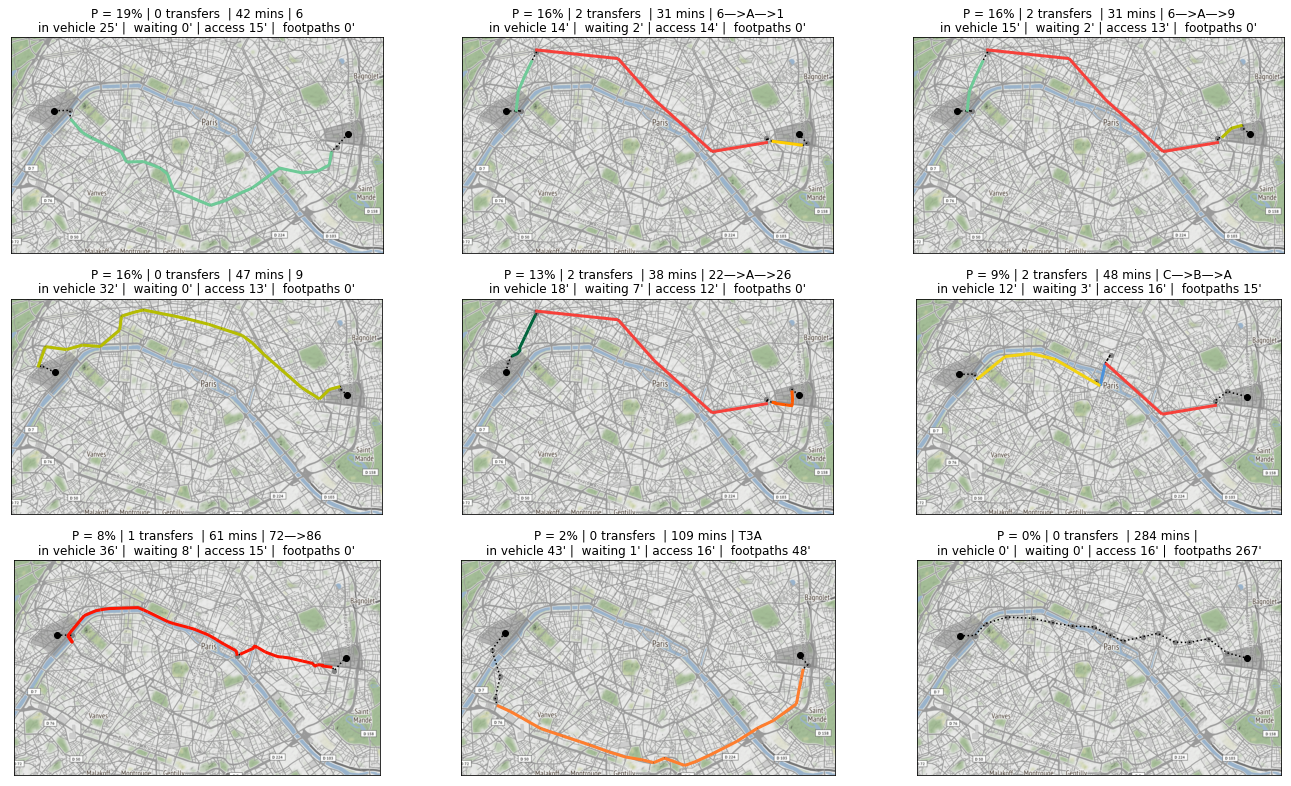

In [68]:
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:
    origin, destination='zone_75',  'zone_106'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True
fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

In [ ]:
fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.26s/it]


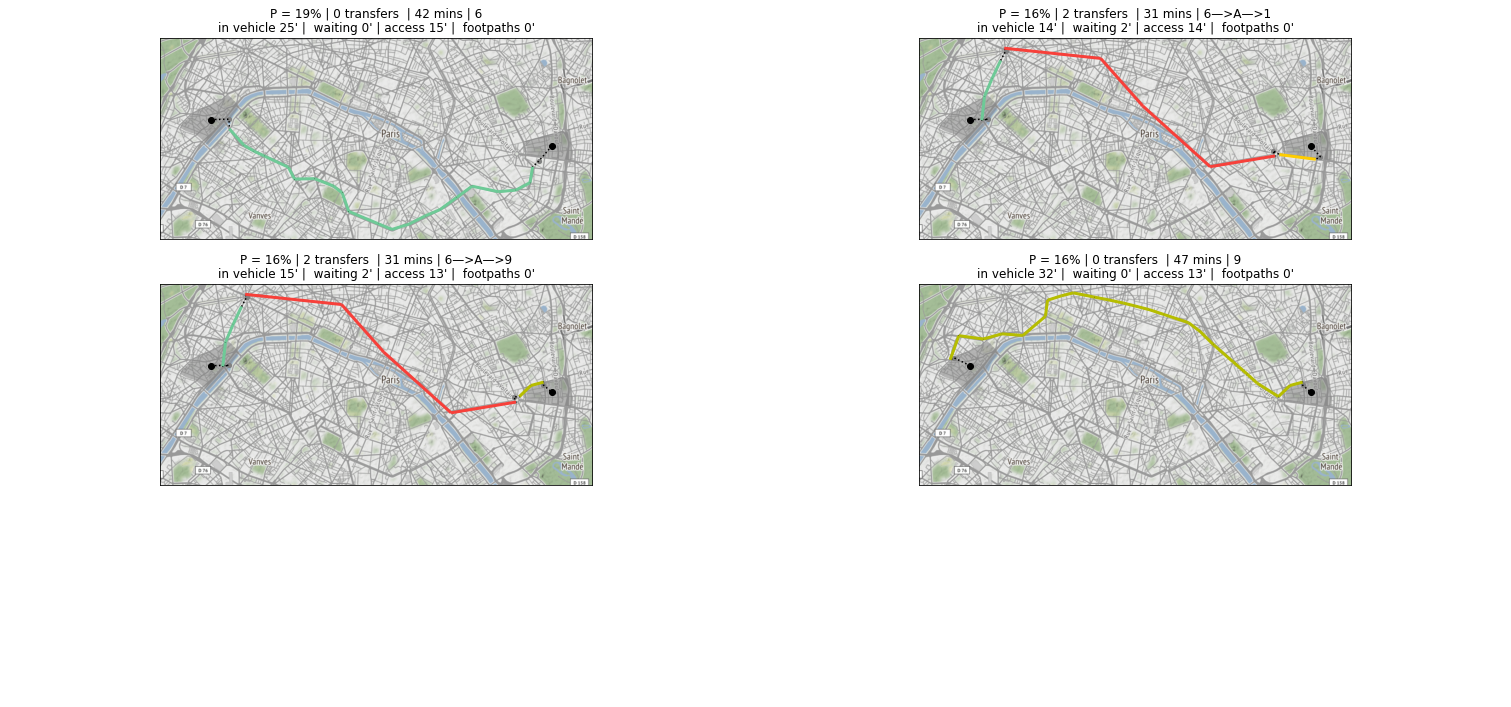

In [67]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.15]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:
    origin, destination='zone_75',  'zone_106'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[15, 15],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True


In [63]:
fig.savefig(plot_path + 'logit.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.13s/it]


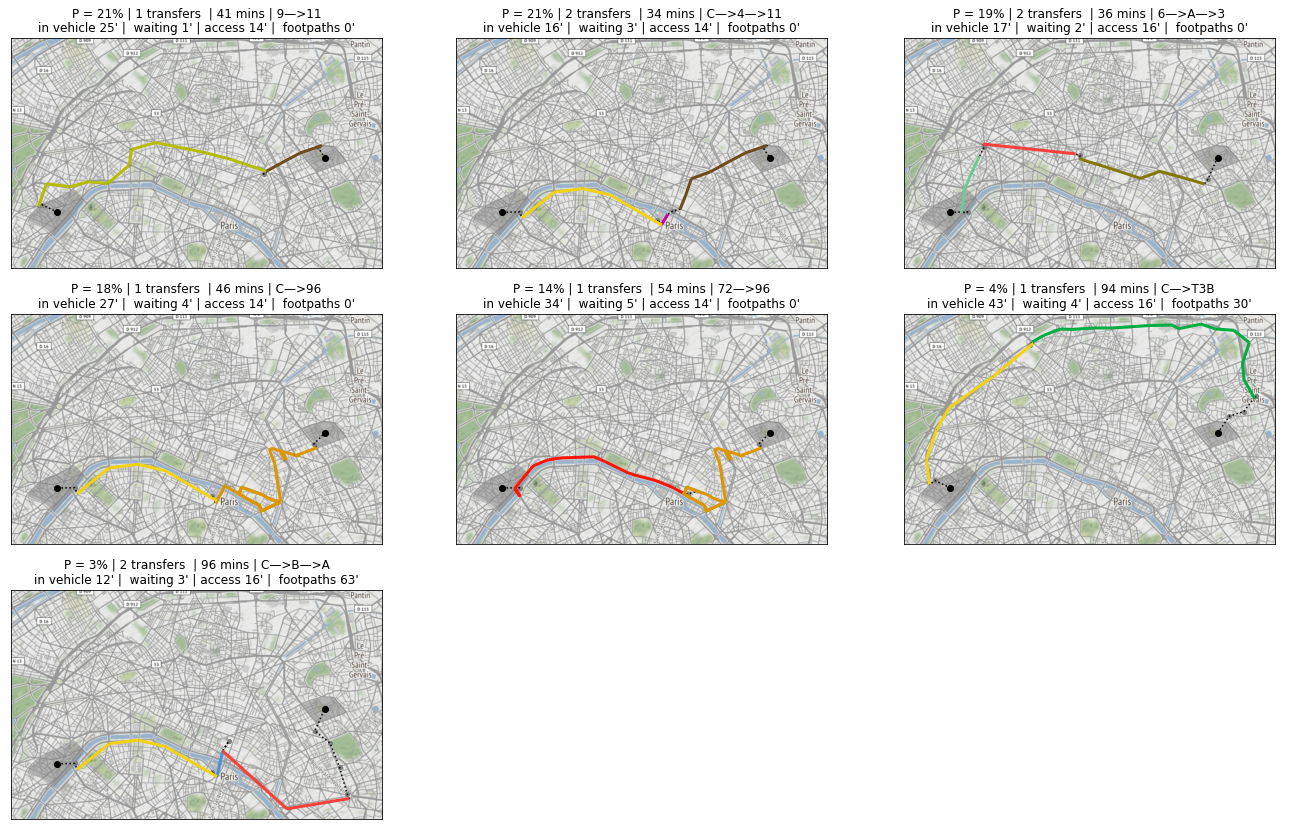

In [55]:
if manual:
    origin, destination='zone_75',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = plot_sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

In [ ]:
plot_sm.pt_los = plot_sm.pt_los.loc[plot_sm.pt_los]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.50s/it]


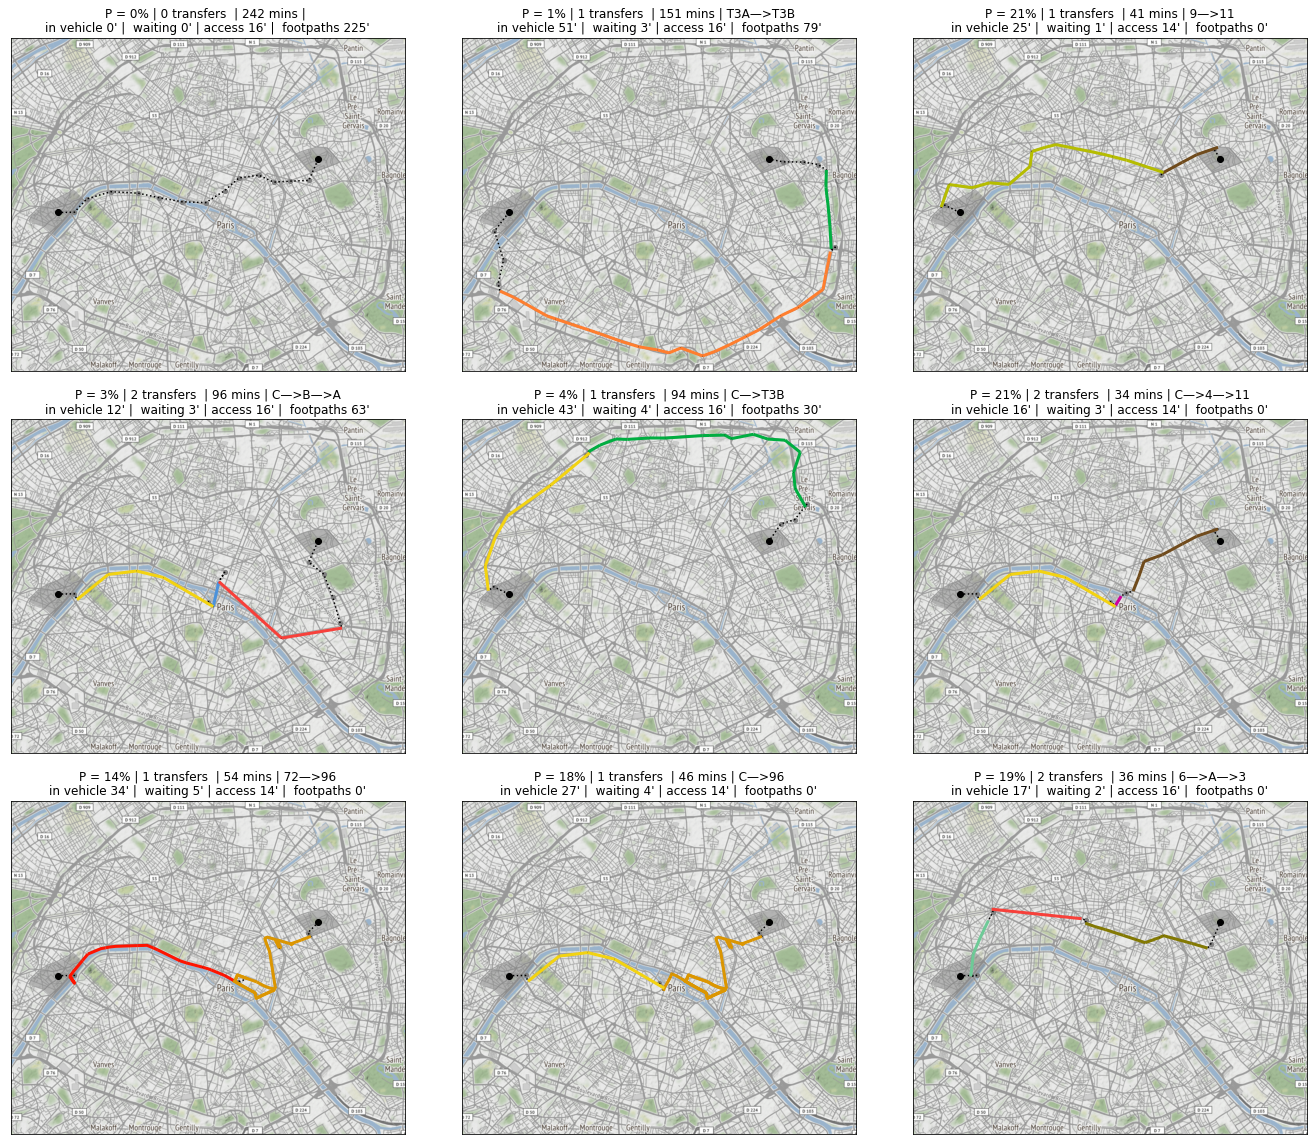

In [42]:
if manual:
    origin, destination='zone_75',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.66it/s]


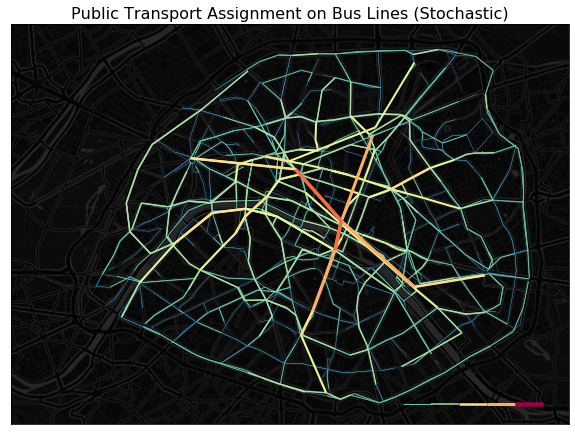

In [41]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000, 15000]
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'

    i_links = sm.loaded_links.loc[sm.loaded_links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    df['pt'] = df['pt_captive'] 
    df = df.loc[df['pt'] > 0]

    plot= bandwidth(
        df, value='pt', power=power, figsize=[10, 10], legend_values=lv, scale=0.5,
        label_kwargs={'color':'white', 'fontsize':14}
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)